In [1]:
import json
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import re
import networkx as nx
from collections import Counter
import time
# Ignore matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the train.json file as data
j_file = open('train.json',)
train_data = json.load(j_file)
#train_data

In [3]:
# read in the data from the dictionary into pandas dataframe in one line of code
# set index to the id column 
df_train = pd.DataFrame.from_dict(train_data)
df_train = df_train.set_index('id')
df_train.head(10)

,cuisine,ingredients
id,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,indian,"[water, vegetable oil, wheat, salt]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge..."
42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli..."
3735,italian,"[sugar, pistachio nuts, white almond bark, flo..."
16903,mexican,"[olive oil, purple onion, fresh pineapple, por..."


In [75]:
df_train['cuisine'].nunique()

20

In [76]:
df_train['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [4]:
#List of all ingredients: list of lists
nested_list_ings = list(df_train.ingredients)

In [5]:
# convert a list of lists to one list 
flat_list_ings =[item for sublist in nested_list_ings for item in sublist]

In [6]:
#len(flat_list_ings)

In [7]:
# stop word search
stop_words_all = [w for w in flat_list_ings if re.search(r'\b ?salt|pepper|sauce|water|seasoning|powder?\b', w)]
#len(stop_words_all)

In [8]:
#convert list to set 
stop_words_set = set(stop_words_all)

In [9]:
#add new column which do not contain stop words
df_train['ingredients_nostopw'] = df_train['ingredients'].apply(lambda x : list(set(x)-stop_words_set))

In [10]:
#df_train.shape

In [11]:
#df_train.head()

In [12]:
#new dataframe with removing list with single items on ingredients_nostopw column
df_train_ext1 = df_train[df_train['ingredients_nostopw'].apply(lambda x: len(x) > 1)]

In [13]:
df_train_ext1.shape

(39633, 3)

In [14]:
#start = time.time()
# from the list of ingredients in a column in given dataframe, this piece will
# return a dictionary of tuples and their weight depending on their presence in a given cuisine.
dic_ings = {}
for i in range(len(df_train_ext1)):
    ing_rows = df_train_ext1['ingredients_nostopw'].iloc[i]
    for ing in ing_rows:
        for ing2 in ing_rows:
            if ing != ing2:
                tup_ings = (ing,ing2)
                if tup_ings in dic_ings.keys():
                    dic_ings[tup_ings] += 1
                else:
                    dic_ings[tup_ings]  = 1
#print(f'{time.time()-start} seconds')

In [15]:
#dic_ings

In [16]:
df_train_dict1 = pd.DataFrame.from_dict(dic_ings, orient = 'index').reset_index()
df_train_dict1.head()

,index,0
0,"(garlic, feta cheese crumbles)",58
1,"(garlic, garbanzo beans)",54
2,"(garlic, black olives)",55
3,"(garlic, purple onion)",399
4,"(garlic, grape tomatoes)",49


In [17]:
df_train_dict1['Source']= df_train_dict1['index'].apply(lambda x: str(x).split(',')[0].replace('(',''))

In [18]:
df_train_dict1['Target']= df_train_dict1['index'].apply(lambda x: str(x).split(',')[1].replace(')',''))

In [19]:
#df_train_dict1.head()

In [20]:
df_train_dict1 = df_train_dict1.rename(columns = {0: 'Weight'})

In [21]:
#df_train_dict1.head()

In [22]:
df_train_dict1['Source'] = df_train_dict1['Source'].replace("\'",'', regex = True) 
df_train_dict1['Target'] = df_train_dict1['Target'].replace("\'",'', regex = True) 

In [23]:
df_train_dict1['Source'] = df_train_dict1['Source'].replace(r"^\s?",'', regex = True) 
df_train_dict1['Target'] = df_train_dict1['Target'].replace(r"^\s?",'', regex = True) 

In [24]:
df_train_dict1.head()

,index,Weight,Source,Target
0,"(garlic, feta cheese crumbles)",58,garlic,feta cheese crumbles
1,"(garlic, garbanzo beans)",54,garlic,garbanzo beans
2,"(garlic, black olives)",55,garlic,black olives
3,"(garlic, purple onion)",399,garlic,purple onion
4,"(garlic, grape tomatoes)",49,garlic,grape tomatoes


In [25]:
type(df_train_dict1['Source'][0])

str

In [26]:
df_train_final = df_train_dict1[['Source', 'Target', 'Weight']].copy() 

In [58]:
df_train_final.head(10)

,Source,Target,Weight
0,garlic,feta cheese crumbles,58
1,garlic,garbanzo beans,54
2,garlic,black olives,55
3,garlic,purple onion,399
4,garlic,grape tomatoes,49
5,garlic,romaine lettuce,48
6,feta cheese crumbles,garlic,58
7,feta cheese crumbles,garbanzo beans,6
8,feta cheese crumbles,black olives,12
9,feta cheese crumbles,purple onion,83


In [28]:
len(df_train_final)

729862

In [29]:
df_train_final.Source

0                                        garlic
1                                        garlic
2                                        garlic
3                                        garlic
4                                        garlic
                          ...                  
729857                       steamed white rice
729858    store bought low sodium chicken stock
729859                     toasted sesame seeds
729860                     toasted sesame seeds
729861                     toasted sesame seeds
Name: Source, Length: 729862, dtype: object

In [30]:
#unique source
uni_source = list(df_train_final.Source.unique())
len(uni_source)

6157

In [31]:
#unique target
uni_target = list(df_train_final.Target.unique())
len(uni_target)

6184

In [32]:
G_all = nx.from_pandas_edgelist(df_train_final,'Source', 'Target',["Weight"])

In [33]:
#print(nx.info(G_all))

In [34]:
#G_all.edges()

In [35]:
len(G_all.nodes())

6192

In [36]:
#G_all.nodes(data=True)

In [37]:
#G_all.edges(data = True)

In [38]:
all_node_list = [f for f, to, edata in G_all.edges(data = True)]
all_node_list_unique = list(set(all_node_list))
len(all_node_list_unique)

3688

In [39]:
selected_edges = [(u,v,e) for u,v,e in G_all.edges(data=True) if e['Weight'] == 150]
#print(selected_edges)

In [40]:
def island_fun(G, weight):
    '''
    Returns a subgraph from a big graph based on the
    selected weight.
    '''
    G1 = nx.Graph()
    for f, to, edata in G.edges(data=True):
         if edata['Weight'] == weight:
                G1.add_edge(f,to, weight = edata['Weight'])
    return G1

In [41]:
island_fun(G_all, 150).edges(data = True)

EdgeDataView([('garlic', 'parsley', {'weight': 150}), ('eggs', 'scallions', {'weight': 150}), ('onions', 'fresh lemon juice', {'weight': 150}), ('sugar', 'cinnamon sticks', {'weight': 150}), ('olive oil', 'ground beef', {'weight': 150}), ('chopped cilantro fresh', 'black beans', {'weight': 150}), ('all-purpose flour', 'shortening', {'weight': 150}), ('sesame seeds', 'rice vinegar', {'weight': 150})])

In [42]:
# sub_graph100 = island_fun(G_all, 100)
# node_list = [f for f, to, edata in sub_graph100.edges(data = True)]
# node_list_unique = list(set(node_list))
# node_list_unique

In [43]:
# node_size = [sub_graph100.degree(sub)*100 for sub in node_list_unique]
#node_size

In [44]:
# plt.figure(figsize=(12, 12))

# layout = nx.spring_layout(sub_graph100,iterations=50)

# nx.draw_networkx_nodes(sub_graph100, 
#                        layout, 
#                        nodelist=node_list_unique, 
#                        node_size=node_size, # a LIST of sizes, based on g.degree
#                        node_color='purple');
# # 

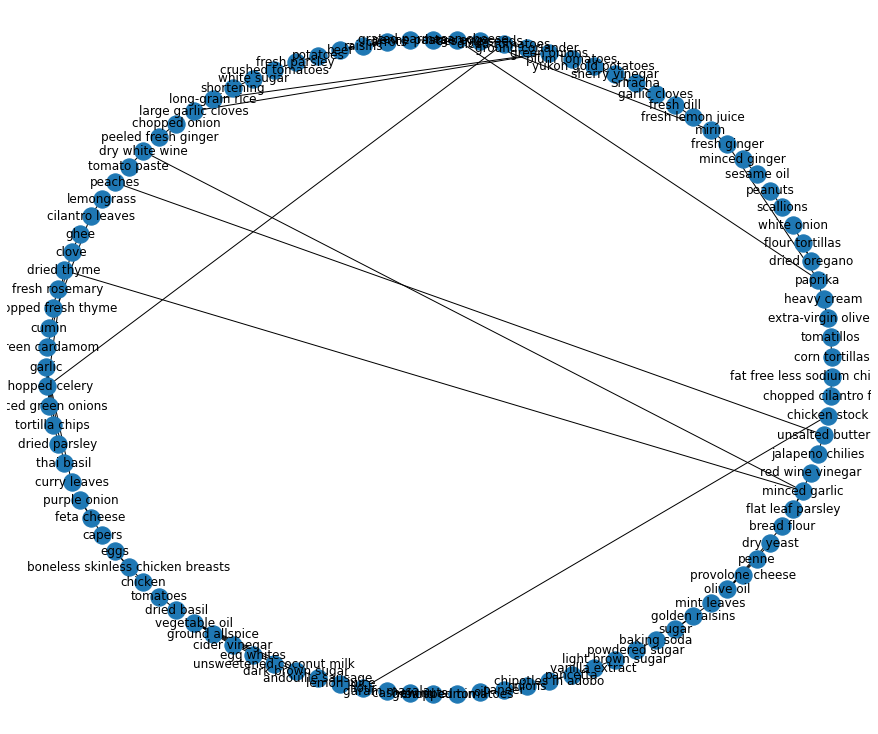

In [73]:
G_plot = island_fun(G_all, 60)
fig = plt.figure(figsize=(12, 10))
nx.draw_shell(G_plot, with_labels=True)
plt.savefig("Ingredients_Graph.png") # save as png

In [70]:
plt.savefig("Ingredients_Graph.png") # save as png

<Figure size 432x288 with 0 Axes>

In [46]:
len(G_all['garlic'])

3217

In [47]:
#list(G_all.nodes())

In [48]:
#G_all['garlic'].keys()#

In [49]:
node_set = set(G_all.nodes())

In [50]:
#%%time
#'shoes' in node_set 

In [51]:
#%%time
#'garlic' in G_all.nodes()

In [52]:
#G_all.nodes()

In [53]:
list_items = [itm for itm in G_all['garlic'].items()]

In [54]:
G_all.neighbors('garlic')

In [55]:
def extract_neigh(G_in, item_search):
    '''
    Returns list of 5 nearest neighbor items 
    sorted with highest value weight for a given search item.
    '''
    list_nodes = [itm for itm, edata in G_in[item_search].items()]
    list_wt = [edata['Weight'] for itm, edata in G_in[item_search].items()]
    data = {'Target_name': list_nodes, 'Weight': list_wt}
    df_out = pd.DataFrame(data)    
    df_out = df_out.sort_values('Weight', ascending = False).reset_index(drop=True)
    nei_list = df_out.Target_name[0:5]    
    return list(nei_list)

In [56]:
#%%time
#extract_neigh(G_all, 'oil')

In [57]:
G_all.degree['garlic']

3217